## In this notebook we will calculate what percent of a home’s average daily energy use is provided by its on-site solar PV-generated power

To prepare the data we selected 50 Texas homes with PV. We used 1 minute energy(from electricity.eg_realpower_1min) data for the selected homes for March 2018 through August 2018.

In [1]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import sqlalchemy as sqla
import os
from config.read_config import get_database_config
from datetime import datetime as dt
import numpy as np
import sys
%matplotlib inline
sys.executable  # shows you your path to the python you're using

'/opt/conda/bin/python'

In [2]:
#Read pre-processed data 
data_df = pd.read_csv('/shared/whole-use-by-solar.gz', compression='gzip')
homes_list = data_df.dataid.unique() 
homes_list

array([3506, 7108, 7030,  171,  744,   93, 1103, 1169, 1354, 1792, 2337,
       2199, 3829, 5129, 5439, 5450, 5615, 5738, 5749, 5892, 6578, 6423,
       7739, 7429, 7627, 7850, 2814, 5784, 6691, 7504, 5109, 7965, 7541,
       3967, 7016, 5035, 5357,  114, 6139, 3368, 6063, 6248, 3009, 3953,
       5658,  379, 5921, 7788, 7024,  499])

In [3]:
#Function to calculate how much energy use was powered by solar for each home for each interval
def calc_use_powered_by_solar(row):

    if row['grid'] < 0 and row['solar'] > 0:

        val = row['total_use']

    elif row['solar'] > 0 and row['grid'] > 0:

        val = row['solar']

    else:

        val = 0

    return val

In [4]:
#replace null with 0's 
data_df = data_df.fillna(0)

#create new column use.
data_df['total_use'] = data_df['grid'] + data_df['solar']

data_df['use_powered_by_solar'] = data_df.apply(calc_use_powered_by_solar, axis=1)

data_df.head(10)

,dataid,localminute,solar,grid,total_use,use_powered_by_solar
0,3506,2018-03-27 07:59:00,0.201,0.628,0.829,0.201
1,7108,2018-03-01 04:59:00,-0.007,0.113,0.106,0.000
2,7108,2018-03-01 05:00:00,-0.007,0.113,0.106,0.000
3,7108,2018-03-01 05:06:00,-0.007,0.109,0.102,0.000
4,7108,2018-03-01 05:16:00,-0.007,0.231,0.224,0.000
5,7108,2018-03-01 05:19:00,-0.007,0.232,0.225,0.000
6,7108,2018-03-01 05:26:00,-0.007,0.225,0.218,0.000
7,7108,2018-03-01 05:29:00,-0.007,0.224,0.217,0.000
8,7108,2018-03-01 05:30:00,-0.007,0.224,0.217,0.000
9,7108,2018-03-01 05:36:00,-0.007,0.113,0.106,0.000


In [5]:
# convert localminute to date
#data_df['dt'] = data_df['localminute'].dt.normalize()

data_df['localminute'] = pd.to_datetime(data_df['localminute'])
data_df['dt'] = data_df['localminute'].dt.date
data_df.head(10)

,dataid,localminute,solar,grid,total_use,use_powered_by_solar,dt
0,3506,2018-03-27 07:59:00,0.201,0.628,0.829,0.201,2018-03-27
1,7108,2018-03-01 04:59:00,-0.007,0.113,0.106,0.000,2018-03-01
2,7108,2018-03-01 05:00:00,-0.007,0.113,0.106,0.000,2018-03-01
3,7108,2018-03-01 05:06:00,-0.007,0.109,0.102,0.000,2018-03-01
4,7108,2018-03-01 05:16:00,-0.007,0.231,0.224,0.000,2018-03-01
5,7108,2018-03-01 05:19:00,-0.007,0.232,0.225,0.000,2018-03-01
6,7108,2018-03-01 05:26:00,-0.007,0.225,0.218,0.000,2018-03-01
7,7108,2018-03-01 05:29:00,-0.007,0.224,0.217,0.000,2018-03-01
8,7108,2018-03-01 05:30:00,-0.007,0.224,0.217,0.000,2018-03-01
9,7108,2018-03-01 05:36:00,-0.007,0.113,0.106,0.000,2018-03-01


In [6]:
#calculate home's daily average use powered by solar
avg_solar_use_by_day = pd.DataFrame(data_df, columns = ['dt','total_use','use_powered_by_solar'])
avg_solar_use_by_day = avg_solar_use_by_day.groupby(['dt']).sum()
avg_solar_use_by_day = avg_solar_use_by_day.reset_index()
avg_solar_use_by_day['use_from_solar'] = (avg_solar_use_by_day['use_powered_by_solar']/avg_solar_use_by_day['total_use'])*100
avg_solar_use_by_day.head(10)

,dt,total_use,use_powered_by_solar,use_from_solar
0,2018-03-01,62428.536,18153.654,29.079096
1,2018-03-02,60181.065,17810.108,29.594205
2,2018-03-03,61372.003,13971.702,22.765596
3,2018-03-04,68961.824,13748.210,19.935972
4,2018-03-05,63894.591,16003.603,25.046882
5,2018-03-06,59143.023,18665.744,31.560348
6,2018-03-07,63467.477,20247.202,31.901697
7,2018-03-08,62856.374,17985.192,28.613155
8,2018-03-09,60739.827,14817.649,24.395277
9,2018-03-10,77522.716,24435.446,31.520369


In [7]:
print(avg_solar_use_by_day['use_from_solar'].mean())

28.735926252275526


In [8]:
#calculate home's weekly average use powered by solar
avg_solar_use_by_week = pd.DataFrame(data_df, columns = ['dt','total_use','use_powered_by_solar'])
avg_solar_use_by_week['dt'] = pd.to_datetime(avg_solar_use_by_week['dt'])
avg_solar_use_by_week['week_num'] = avg_solar_use_by_week['dt'].dt.week
#avg_solar_use_by_week['week_num'] = avg_solar_use_by_week['dt'].dt.week
avg_solar_use_by_week = avg_solar_use_by_week.groupby(['week_num']).sum()
avg_solar_use_by_week = avg_solar_use_by_week.reset_index()
avg_solar_use_by_week['use_from_solar'] = (avg_solar_use_by_week['use_powered_by_solar']/avg_solar_use_by_week['total_use'])*100
avg_solar_use_by_week.head(10)




<ipython-input-8-6ab6a6088004>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  avg_solar_use_by_week['week_num'] = avg_solar_use_by_week['dt'].dt.week


,week_num,total_use,use_powered_by_solar,use_from_solar
0,9,252943.428,63683.674,25.177042
1,10,451179.350,126116.262,27.952579
2,11,479069.910,136404.684,28.472814
3,12,467094.286,132788.912,28.428717
4,13,479883.765,137510.811,28.655025
5,14,477884.767,129591.479,27.117725
6,15,453579.921,143449.822,31.626140
7,16,447405.209,142137.577,31.769317
8,17,510053.529,163787.546,32.111835
9,18,563664.568,127691.904,22.653882


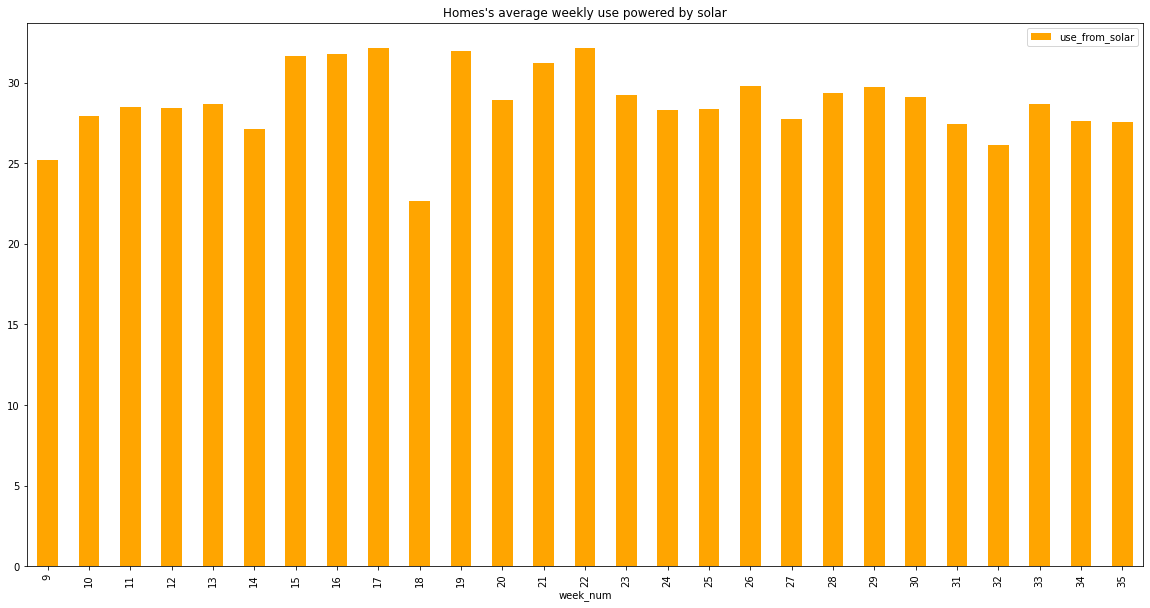

In [9]:
#plot bar chart for average weekly use
avg_solar_use_by_week.plot.bar(x='week_num', y='use_from_solar',figsize=(20,10),color='orange',title="Homes's average weekly use powered by solar")
plt.show()

## From above analysis we see that 29% of home’s average daily energy use is provided by its on-site solar PV-generated power.